# Exploratory Data Analysis
Methods:  
1. Spatial distribution/range of each type of purpose
2. 
3. 
4. 

#TODO# Clean up

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import numpy as np
import seaborn as sns
import datetime

from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext


%matplotlib inline

# Load in data

In [2]:
X_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_y.csv')

In [3]:
# combine both X, y and date times
all_17 = pd.concat([X_17, y_17],axis=1)

# merge the times for start and end of trip
start_end_times = gpd.read_file('../../Data/mtl_trajet/mtl_trajet_2017_final.shp')[['id_trip','starttime','endtime']]
all_17 = all_17.merge(start_end_times, on='id_trip')

# turn these new columns into datetime objects
all_17['starttime'] = pd.to_datetime(all_17['starttime'])
all_17['endtime'] = pd.to_datetime(all_17['endtime'])

In [4]:
mtl_region = gpd.read_file("../../Data/shapes/mtl_regions.json")
mtl_dissem = gpd.read_file("../../Data/shapes/mtl_dissem.geojson")
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

## turn into GeoDataFrame

In [5]:
all_17['start_point'] = all_17.apply(lambda row: \
                                                     shapely.geometry.Point(row['startx'],row['starty']), axis=1)
all_17['end_point'] = all_17.apply(lambda row: \
                                                     shapely.geometry.Point(row['endx'],row['endy']), axis=1)

In [6]:
gdf_17 = gpd.GeoDataFrame(all_17, geometry='end_point')

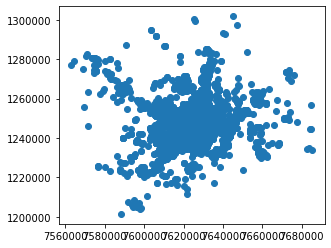

In [7]:
gdf_17.plot()

## Spatial Range of each purpose

In [8]:
gdf_17

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,...,midnight,startx,starty,endx,endy,purpose,starttime,endtime,start_point,end_point
0,150744,2,862,9935.922336,1,0.000000e+00,16.910884,True,False,False,...,False,7.624322e+06,1.247673e+06,7.631864e+06,1.250415e+06,3,2017-09-18 10:02:50,2017-09-18 10:17:12,POINT (7624322.265039734 1247672.970059557),POINT (7631863.767736511 1250414.940902894)
1,35763,2,1873,6832.113937,1,9.972328e-07,18.007062,False,True,False,...,False,7.641919e+06,1.236661e+06,7.641941e+06,1.236732e+06,2,2017-09-18 11:32:54,2017-09-18 12:04:07,POINT (7641918.591122853 1236660.830229698),POINT (7641940.751710543 1236732.42094018)
2,323826,2,1165,12233.968564,1,9.972328e-07,18.007062,False,True,False,...,False,7.625699e+06,1.248427e+06,7.616671e+06,1.252917e+06,5,2017-09-18 12:25:08,2017-09-18 12:44:33,POINT (7625699.094351658 1248426.57008442),POINT (7616671.176450541 1252917.246846175)
3,375668,2,820,3612.405991,1,1.495849e-06,20.940647,False,True,False,...,False,7.630948e+06,1.253394e+06,7.630941e+06,1.253445e+06,0,2017-09-18 13:15:20,2017-09-18 13:29:00,POINT (7630948.030943782 1253393.894894515),POINT (7630940.820018931 1253445.275340939)
4,212877,2,1316,26428.385191,1,1.495849e-06,23.092603,False,False,True,...,False,7.631318e+06,1.252962e+06,7.646416e+06,1.264378e+06,0,2017-09-18 13:39:44,2017-09-18 14:01:40,POINT (7631317.888935089 1252962.189750378),POINT (7646416.072621653 1264377.507510747)
5,14699,0,1668,1275.056162,1,2.742390e-05,25.618059,False,False,True,...,False,7.631673e+06,1.244415e+06,7.631896e+06,1.244344e+06,0,2017-09-18 16:06:48,2017-09-18 16:34:36,POINT (7631672.620555586 1244415.470094826),POINT (7631896.245007073 1244343.63790057)
6,443357,0,1127,650.601955,1,4.238239e-05,26.384436,False,False,False,...,False,7.631364e+06,1.244779e+06,7.631361e+06,1.245062e+06,2,2017-09-18 17:04:11,2017-09-18 17:22:58,POINT (7631364.03766227 1244778.994283486),POINT (7631360.997841966 1245061.617401482)
7,256254,0,129,85.844452,1,4.238239e-05,26.384436,False,False,False,...,False,7.632850e+06,1.244075e+06,7.632808e+06,1.244086e+06,2,2017-09-18 17:26:42,2017-09-18 17:28:51,POINT (7632849.854618313 1244075.294144143),POINT (7632807.775660807 1244085.778065081)
8,142829,0,217,160.435726,1,4.238239e-05,26.384436,False,False,False,...,False,7.631399e+06,1.244926e+06,7.631357e+06,1.244778e+06,2,2017-09-18 17:32:57,2017-09-18 17:36:34,POINT (7631399.197178218 1244925.510657259),POINT (7631356.91559275 1244778.181420083)
9,276155,3,1743,7956.412449,1,6.182843e-05,26.659408,False,False,False,...,False,7.632126e+06,1.244495e+06,7.630498e+06,1.249978e+06,2,2017-09-18 20:11:10,2017-09-18 20:40:13,POINT (7632125.578461927 1244494.922663878),POINT (7630497.787466216 1249978.204292289)


## Purpose by time period
Time periods:
Morning, Midday, Afternoon, Evening, Midnight

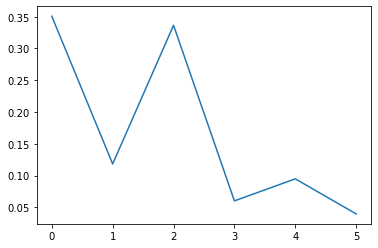

In [9]:
plt.plot(all_17.groupby('purpose').count()['mode'] / all_17.groupby('purpose').count()['mode'].sum())

In [10]:
time_periods = ['morning', 'midday', 'afternoon', 'evening', 'midnight']
PURPOSE_CLASSES = {0:'leisure', 1:'food_drink', 2:'shops', 3:'pick_up_drop_off',  4:'education', 5:'health'}

In [11]:
col = time_periods[0]

In [12]:
all_17.loc[all_17[col] == True]

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,...,midnight,startx,starty,endx,endy,purpose,starttime,endtime,start_point,end_point
0,150744,2,862,9935.922336,1,0.000000e+00,16.910884,True,False,False,...,False,7.624322e+06,1.247673e+06,7.631864e+06,1.250415e+06,3,2017-09-18 10:02:50,2017-09-18 10:17:12,POINT (7624322.265039734 1247672.970059557),POINT (7631863.767736511 1250414.940902894)
31,446594,2,2560,31138.958368,1,0.000000e+00,18.477029,True,False,False,...,False,7.626135e+06,1.244509e+06,7.619534e+06,1.235502e+06,0,2017-09-19 07:51:16,2017-09-19 08:33:56,POINT (7626135.431853012 1244509.162033076),POINT (7619533.714791068 1235502.111053606)
32,464374,3,832,1985.883381,1,0.000000e+00,18.164130,True,False,False,...,False,7.632402e+06,1.247812e+06,7.631952e+06,1.248840e+06,2,2017-09-19 09:37:11,2017-09-19 09:51:03,POINT (7632402.078246191 1247812.12166365),POINT (7631952.277242373 1248839.891040089)
33,101335,3,1465,5115.627123,1,0.000000e+00,17.907297,True,False,False,...,False,7.627348e+06,1.247840e+06,7.628020e+06,1.244450e+06,5,2017-09-19 09:56:48,2017-09-19 10:21:13,POINT (7627347.996983065 1247840.452527924),POINT (7628019.73121427 1244449.557835266)
263,272694,1,8818,10466.999819,1,0.000000e+00,16.448955,True,False,False,...,False,7.629533e+06,1.246780e+06,7.590401e+06,1.263820e+06,5,2017-09-20 08:23:36,2017-09-20 10:50:34,POINT (7629533.109492058 1246780.015577729),POINT (7590400.542254705 1263819.757166244)
264,117804,0,3374,6517.679059,1,0.000000e+00,16.299926,True,False,False,...,False,7.626985e+06,1.240925e+06,7.627778e+06,1.241010e+06,0,2017-09-20 09:31:20,2017-09-20 10:27:34,POINT (7626985.193109789 1240924.519119593),POINT (7627777.943363953 1241009.883753738)
473,197541,0,559,483.366793,1,0.000000e+00,17.200285,True,False,False,...,False,7.625969e+06,1.247194e+06,7.625727e+06,1.247442e+06,1,2017-09-21 05:58:16,2017-09-21 06:07:35,POINT (7625968.52865138 1247193.681643712),POINT (7625727.324865495 1247441.949152012)
474,211343,0,812,531.674432,1,0.000000e+00,17.200285,True,False,False,...,False,7.630989e+06,1.244247e+06,7.630608e+06,1.244133e+06,1,2017-09-21 06:03:12,2017-09-21 06:16:44,POINT (7630989.488918813 1244247.163342367),POINT (7630608.061473955 1244132.617376021)
475,12581,1,1574,24306.377632,1,0.000000e+00,15.635788,True,False,False,...,False,7.622767e+06,1.243734e+06,7.627861e+06,1.243658e+06,4,2017-09-21 10:31:02,2017-09-21 10:57:16,POINT (7622766.579675769 1243733.853629399),POINT (7627860.639201453 1243657.965203343)
702,49089,0,1255,641.911246,1,0.000000e+00,14.443555,True,False,False,...,False,7.629755e+06,1.246309e+06,7.629897e+06,1.246812e+06,0,2017-09-22 06:46:05,2017-09-22 07:07:00,POINT (7629754.520008188 1246308.732352398),POINT (7629896.922691602 1246812.401903044)


In [13]:
pur_hours = {}
for tp in time_periods:
    tp_df = all_17.loc[all_17[tp] == True]
    pur_counts = ((tp_df['purpose'].value_counts()  / tp_df['purpose'].value_counts().sum())*100).to_dict()
    pur_hours[tp] = pur_counts

In [14]:
pur_hours

{'morning': {0: 49.282296650717704,
  5: 17.22488038277512,
  1: 12.918660287081341,
  2: 10.526315789473683,
  3: 5.263157894736842,
  4: 4.784688995215311},
 'midday': {4: 35.06591337099812,
  2: 19.661016949152543,
  0: 18.757062146892657,
  3: 11.525423728813559,
  5: 7.758945386064029,
  1: 7.231638418079096},
 'afternoon': {2: 40.0225988700565,
  0: 25.853107344632768,
  1: 16.610169491525422,
  4: 9.898305084745761,
  5: 4.293785310734463,
  3: 3.3220338983050843},
 'evening': {2: 42.0212171970966,
  0: 31.300949190396427,
  1: 9.983249581239532,
  4: 6.968174204355108,
  3: 6.164154103852596,
  5: 3.562255723059743},
 'midnight': {0: 52.22255369928401,
  2: 24.537589498806682,
  1: 12.91766109785203,
  3: 5.414677804295943,
  4: 2.56563245823389,
  5: 2.341885441527446}}

[49.282296650717704, 12.918660287081341, 10.526315789473683, 5.263157894736842, 4.784688995215311, 17.22488038277512]
[18.757062146892657, 7.231638418079096, 19.661016949152543, 11.525423728813559, 35.06591337099812, 7.758945386064029]
[25.853107344632768, 16.610169491525422, 40.0225988700565, 3.3220338983050843, 9.898305084745761, 4.293785310734463]
[31.300949190396427, 9.983249581239532, 42.0212171970966, 6.164154103852596, 6.968174204355108, 3.562255723059743]
[52.22255369928401, 12.91766109785203, 24.537589498806682, 5.414677804295943, 2.56563245823389, 2.341885441527446]


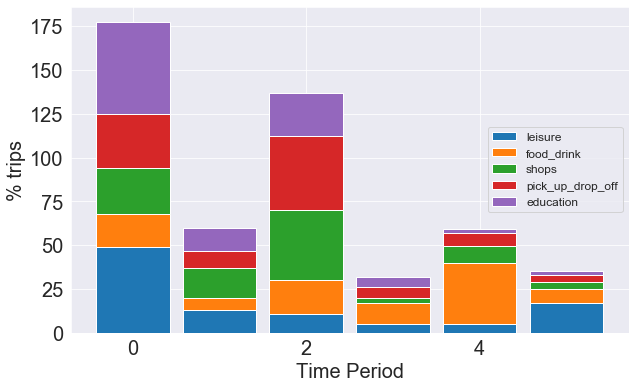

In [15]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(10,6))
ind = np.arange(len(PURPOSE_CLASSES.values()))    # the x locations for the groups
width = 0.85      # the width of the bars: can also be len(x) sequence
for i, md in zip(range(len(time_periods)), time_periods):
    vals = []
    for key in sorted(pur_hours[md]):
        vals.append(pur_hours[md][key])
    print(vals)
    if i == 0: 
        first_vals = vals
        ax.bar(ind, vals, width)
    elif i == 1:
        ax.bar(ind, vals, width, first_vals)
        first_vals = np.add(first_vals, vals).tolist()
    else:
        ax.bar(ind, vals, width, first_vals)
        first_vals = np.add(first_vals, vals).tolist()
    ax.legend(PURPOSE_CLASSES.values(), bbox_to_anchor=(1, .65), fontsize=12)
    plt.xticks(np.arange(0,len(PURPOSE_CLASSES.values()), 2), size=20)
    plt.yticks(size=20)
    ax.set_xlabel("Time Period", size=20)
    ax.set_ylabel("% trips", size=20)

## Trips per hour

In [16]:
data = predictions_17_gdf.set_index('starttime').groupby([pd.Grouper(freq='1h')]).agg({'id_trip':'count'})
data_per_hour_t = pd.concat([data[data.index.hour == x].reset_index()['id_trip'] for x in range(0,24)], axis=1).T
data_per_hour_t.index = np.arange(0,24)
data_per_hour_t.columns = [str(dt.date()) for dt in pd.date_range('2017-09-18', '2017-10-17', freq='D')]
data_per_hour_t.head()

NameError: name 'predictions_17_gdf' is not defined

In [ ]:
fig, ax = plt.subplots(1, figsize=(14,4))
sns.heatmap(data_per_hour_t.T,ax=ax, linewidths=.1, annot=False, fmt='.0f', cbar_kws={'label': 'Count of Trips', "orientation": "vertical"});
ax.set_xticklabels(labels=np.arange(0,24),rotation=0);
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(size=12)
plt.xlabel("Hour of Day", size=16)
plt.ylabel("Date", size=16)
# plt.title("", size=18)
# plt.savefig("figures/grouped_hour_heatmap.png", bbox_inches='tight')